In [1]:
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

2025-04-30 18:36:40.604260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746038200.908171      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746038200.996099      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATASET_PATH = "/kaggle/input/lung-cancer-histopathological-images"
WORKING_DIR = "/kaggle/working/dataset"
if not os.path.exists(WORKING_DIR):
    shutil.copytree(DATASET_PATH, WORKING_DIR)

In [3]:
classes = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]

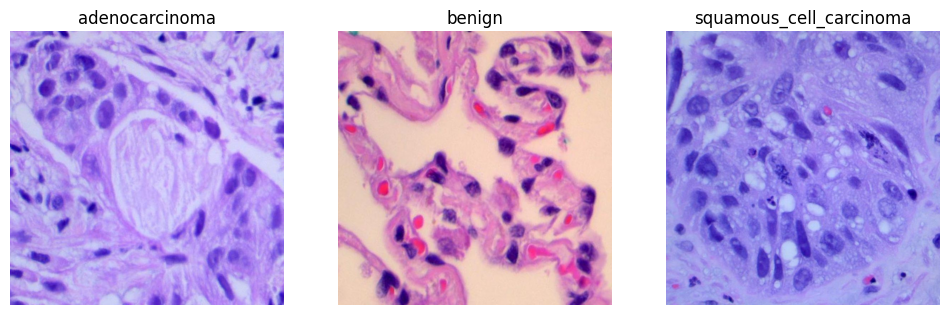

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(classes):
    img_path = os.path.join(WORKING_DIR, label)
    img_file = random.choice(os.listdir(img_path))
    img = cv2.imread(os.path.join(img_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()

In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 1

# Create ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    fill_mode='nearest'
)
# trying squeezenet with basically no augumentation to get a clearer picture
# Load training data
train_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [13]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/input/lung_cancer_squeezenet_int8/tflite/default/1/squeezenet_lung_cancer_unaugumented_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("TFLite model loaded successfully!")

TFLite model loaded successfully!


In [14]:
correct = 0
total = 0
all_preds = []
all_trues = []

In [15]:
for i in range(len(val_data)):
    img, label = val_data[i]  # Get a batch of images and labels

    # Preprocess and run inference for the whole batch
    #check the input type. If it is not float32, change it.
    if input_details[0]['dtype'] != np.float32:
        img = img.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], img.astype(input_details[0]['dtype']))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])  # Get the batch of predictions

    # Convert predictions and true labels to numpy arrays
    preds = np.argmax(output, axis=1)  # Get class predictions for the batch
    trues = np.argmax(label, axis=1)    # Get true class labels for the batch

    # Update counters for accuracy
    correct += np.sum(preds == trues)
    total += len(trues)

    # Extend the lists for precision, recall, and f1
    all_preds.extend(preds)
    all_trues.extend(trues)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

TFLite INT8 Model Accuracy: 33.33%
TFLite INT8 Model Precision: 11.11%
TFLite INT8 Model Recall: 33.33%
TFLite INT8 Model F1 Score: 16.67%

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.00      0.00      0.00      1000
                 benign       0.33      1.00      0.50      1000
squamous_cell_carcinoma       0.00      0.00      0.00      1000

               accuracy                           0.33      3000
              macro avg       0.11      0.33      0.17      3000
           weighted avg       0.11      0.33      0.17      3000



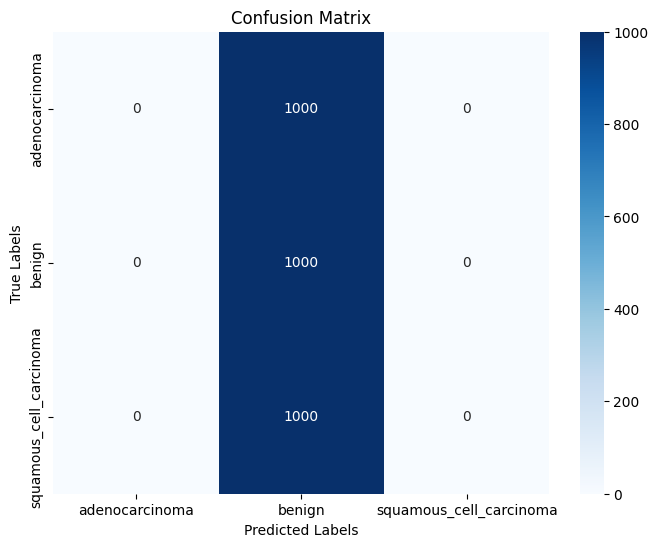

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
accuracy = correct / total
precision = precision_score(all_trues, all_preds, average='macro')
recall = recall_score(all_trues, all_preds, average='macro')
f1 = f1_score(all_trues, all_preds, average='macro')

# Print metrics
print(f"TFLite INT8 Model Accuracy: {accuracy * 100:.2f}%")
print(f"TFLite INT8 Model Precision: {precision * 100:.2f}%")
print(f"TFLite INT8 Model Recall: {recall * 100:.2f}%")
print(f"TFLite INT8 Model F1 Score: {f1 * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_trues, all_preds, target_names=classes)) # Use the classes list

# Confusion Matrix
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes) # Use the classes list
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
